In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 5)

In [2]:
import numpy as np
from scipy.spatial import Delaunay

In [3]:
SEGMENT_COUNT = 10
SEGMENT_LENGTH = 3.0
TRACK_WIDTH = 3.0
POSITION_NOISE_STD = 0.4
OUTLIER_COUNT_MEAN = 5
OUTLIER_COUNT_STD = 5

rng = np.random.default_rng()

def cos_sin(angle):
    return np.column_stack((np.cos(angle), np.sin(angle)))

def make_track_sample():
    angle_diff = rng.standard_normal(SEGMENT_COUNT) * np.pi / 35.0
    angle_diff[0] = 0
    angle_diff[1] = 0
    angle_relative = np.cumsum(angle_diff)
    angle_absolute = np.cumsum(angle_relative)


    segments = cos_sin(angle_absolute) * SEGMENT_LENGTH
    normals = cos_sin(angle_absolute + np.pi / 2)
    segments[0] = [0, 0]
    middle = np.cumsum(segments, axis=0)
    left = middle + normals * TRACK_WIDTH / 2
    right = middle - normals * TRACK_WIDTH / 2
    
    left += rng.standard_normal((SEGMENT_COUNT, 2)) * POSITION_NOISE_STD
    right += rng.standard_normal((SEGMENT_COUNT, 2)) * POSITION_NOISE_STD
    
    mask = rng.standard_normal((2, SEGMENT_COUNT)) < 1.2
    left = left[mask[0]]
    right = right[mask[1]]
    
    outlier_count = abs(int(rng.standard_normal() * OUTLIER_COUNT_STD + OUTLIER_COUNT_MEAN))
    outliers = ((rng.random((outlier_count, 2)) - 0.5) * 30 + [15, 0])

    return left, right, middle, outliers

def plot_cones(xy, m=None):
    plt.plot(xy[:,0], xy[:,1], 'o')
    if m is not None:
        plt.plot(m[:,0], m[:,1], '-o')
    plt.axis('equal')

def triplot(vertices, simplices):
    plt.triplot(vertices[:,0], vertices[:,1], simplices)
    
def plot_random_track_sample_basic():
    left, right, middle, outliers = make_track_sample()
    cones = np.concatenate((left, right, outliers))
    rng.shuffle(cones, axis=0)
    tri = Delaunay(cones)
    triplot(cones, tri.simplices)
    plot_cones(cones, middle)
    plot_cones(outliers)
    plt.show()
    
import shapely.ops
from shapely.geometry import MultiPoint, LineString, Polygon
from descartes.patch import PolygonPatch

def plot_random_track_sample(ax=None):
    if ax is None:
        ax = plt.figure().add_subplot(1,1,1)

    left_cones, right_cones, middle, outlier_cones = make_track_sample()
    all_cones = np.concatenate((left_cones, right_cones, outlier_cones))
    cone_points = MultiPoint(all_cones)
    middle_line = LineString(middle[:])
    triangles = shapely.ops.triangulate(cone_points)
    labels = [middle_line.intersects(t) for t in triangles]

    for triangle, label in zip(triangles, labels):
        facecolor = [0.5,0,0] if label else [0,0,1.0]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            patch = PolygonPatch(triangle, facecolor=facecolor, edgecolor=[0,0,1], alpha=0.5, zorder=2)
        ax.add_patch(patch)
    plot_cones(all_cones, middle)
    plot_cones(left_cones)
    plot_cones(right_cones)
    plt.axis('equal')
    
import warnings
def plot_grid_of_samples(cols=4, rows=1):
    fig = plt.figure(figsize=(20, rows * 5))
    for i in range(rows * cols):
        ax = fig.add_subplot(rows , cols, i+1)
        plot_random_track_sample(ax)
    plt.show()
    
import torch
import torch_geometric

def make_triangle_graph(cones):
    triangulation = Delaunay(cones)
    edge_index = np.array([
        [node, neigh] 
        for node, neighbors in enumerate(triangulation.neighbors) 
        for neigh in neighbors 
        if neigh != -1
    ]).T
    vertices = triangulation.points[triangulation.simplices]
    centroid = [np.array(Polygon(v).centroid.coords.xy).T[0] for v in vertices]
    return torch_geometric.data.Data(
        num_nodes=len(centroid),
        x=torch.tensor(vertices, dtype=torch.float), 
        pos=torch.tensor(centroid, dtype=torch.float), 
        edge_index=torch.tensor(edge_index, dtype=torch.long)
    )

def make_cones_graph(cones, labels=None):
    triangulation = Delaunay(cones)
    indptr, indices = triangulation.vertex_neighbor_vertices
    edge_index = np.array([
        [node, neigh] 
        for node, (i, j) in enumerate(zip(indptr[:-1], indptr[1:]))
        for neigh in indices[i:j]
    ]).T
    return torch_geometric.data.Data(
        num_nodes=len(cones),
        x=torch.tensor(cones, dtype=torch.float), 
        y=torch.tensor(labels, dtype=torch.float) if labels is not None else None, 
        pos=torch.tensor(cones, dtype=torch.float), 
        edge_index=torch.tensor(edge_index, dtype=torch.long)
    )

import networkx as nx

def draw_graph(data):
    g = torch_geometric.utils.to_networkx(data, to_undirected=True, node_attrs=['pos', 'y'])
    pos = [v['pos'] for v in g.nodes.values()]
    color = [v['y'] for v in g.nodes.values()]
    nx.draw(g, pos, with_labels = True, node_color=color)
    plt.axis('equal')
    # plt.figure()
    # triplot(cones, tri.simplices)

In [4]:
def plot_graph_sample():
    left, right, middle, outliers = make_track_sample()
    cones = np.concatenate((left, right, outliers))
    labels = np.zeros((len(cones), 3))
    labels[:len(left), 0] = 1.0
    labels[len(left):len(right)+len(left), 1] = 1.0
    if len(outliers):
        labels[-len(outliers):, 2] = 1.0
    tri = Delaunay(cones)
    data = make_cones_graph(cones, labels)
    draw_graph(data)

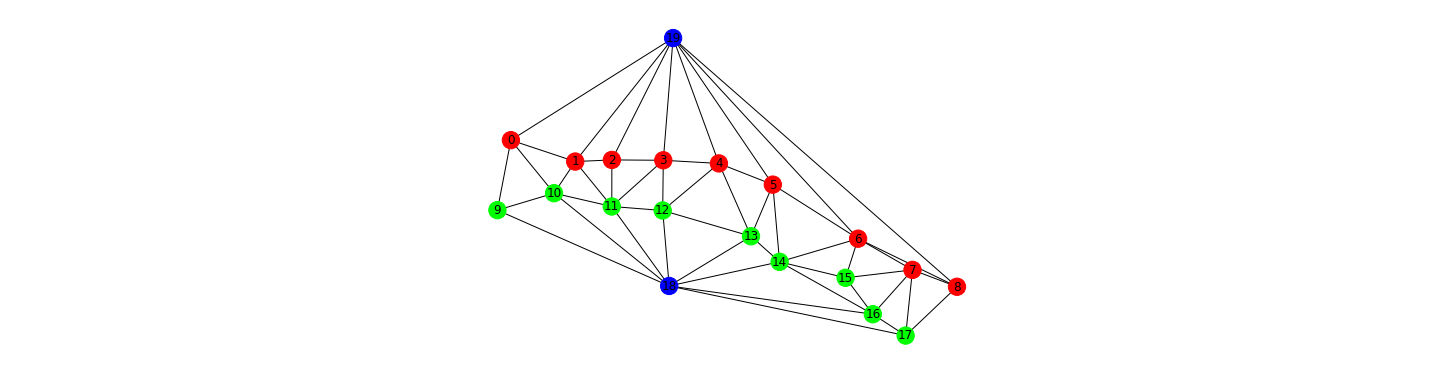

In [13]:
plot_graph_sample()

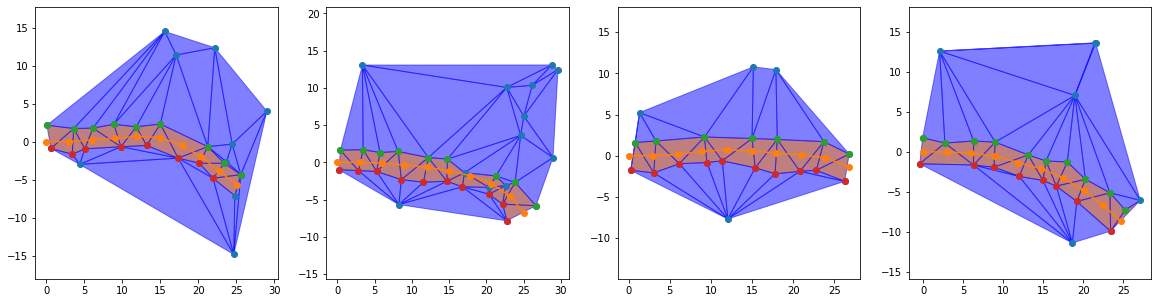

In [15]:
plot_grid_of_samples()